In [28]:
# load libraries
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [15]:
# load saved training/validation/test data
with open('train_val_test_data.pkl', 'rb') as file:
    X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(file)

In [16]:
# select specific features of the input passwords
rf_features = ['length', 'uppercase_count', 'lowercase_count', 'numbers_count', 'special_character_count', 'entropy']
X_train = X_train[rf_features].to_numpy()
X_val = X_val[rf_features].to_numpy()
X_test = X_test[rf_features].to_numpy()

In [17]:
# flatten the label data
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()

In [18]:
# calculate accuracy given the true labels and the predictions
def accuracy(y_truth, y_pred):
    correct_pred = 0
    # iterate through the values and check if the labels are the same, update as required
    for y_t, y_p in zip(y_truth, y_pred):
        if y_t == y_p :
            correct_pred += 1
    # find the proportion by dividing the correct predictions by all the predictions
    return correct_pred / len(y_truth)

In [19]:
# calculate Gini impurity, calculate error based on random classification 
def gini_impurity(y):
    # find the counts of each class/label
    class_counts = np.bincount(y.flatten())
    # find the distribution of samples across the classes
    probabilities = class_counts / len(y)
    # calculate the error and return
    return 1 - np.sum(probabilities ** 2)

In [20]:
# calculate Shannon Entropy, measures unpredictability of password
def entropy(y):
    # find the counts of each class/label
    class_counts = np.bincount(y.flatten())
    # find the distribution of samples across the classes
    probabilities = class_counts / len(y)
    # to avoid log(0), add a small value to zero probabilities
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))

In [ ]:
# finds the thresholds given the column of values and number of thresholds and indication of randomness
def calculate_thresholds(feature_column, n_thresholds, extra_trees):
    # if using extra trees, pick random thresholds from continuous range
    if extra_trees:
        # find minimum and maximum of this feature's values
        feature_min = feature_column.min()
        feature_max = feature_column.max()
        # if there is only one possible value, just use that as the threshold
        if feature_min == feature_max:
            return np.unique(feature_column)
        # otherwise pick random thresholds from a continuous range between minimum and maximum
        else:
            return np.random.uniform(feature_min, feature_max, size=n_thresholds or 10)
    # use random sampling of thresholds if n_thresholds is specified
    elif n_thresholds is not None:
        # randomly sample n thresholds from unique values of feature column
        return np.random.choice(np.unique(feature_column), min(n_thresholds, len(np.unique(feature_column))), replace=False)
    else:
        # find all unique values in the feature column
        return np.unique(feature_column)

In [ ]:
# evaluate a single split to see what the impurity for this feature's threshold will be
def evaluate_split(feature_column, y, threshold, criterion):
    # find all the samples whose values in the feature column are less than the threshold
    left_node_samples = y[feature_column < threshold]
    # find all the samples whose values in the feature column are greater than or equal to the threshold
    right_node_samples = y[feature_column >= threshold]
    
    # if there are samples on either side of the threshold value, then calculate the impurity and update as required
    # essentially filters out invalid thresholds that may be greater/less than all the samples
    if len(left_node_samples) != 0 and len(right_node_samples) != 0:
        # use the appropriate criterion
        if criterion == 'entropy':
                # calculate the entropy of the left node samples
            left_impurity = entropy(left_node_samples)
            # calculate the entropy of the right node samples
            right_impurity = entropy(right_node_samples)
        elif criterion == 'gini':
            # calculate the impurity of the left node samples
            left_impurity = gini_impurity(left_node_samples)
            # calculate the impurity of the right node samples
            right_impurity = gini_impurity(right_node_samples)
        # find the weighted impurity value (expectation)
        return (len(left_node_samples) * left_impurity + len(right_node_samples) * right_impurity) / len(y)
    return None

In [ ]:
# evaluate the splits to see which features and thresholds will be the best
def evaluate_splits(feature_column, y, thresholds, criterion, min_impurity, feature):
    # for each threshold value, it is trying to minimize the gini impurity
    for threshold in thresholds:
        # find the impurity of the this threshold for this feature
        weighted_impurity = evaluate_split(feature_column, y, threshold, criterion)
        # if the weighted impurity is less than the current minimum impurity, then update the values
        if weighted_impurity is not None and weighted_impurity < min_impurity:
            min_impurity = weighted_impurity
            min_impurity_feature = feature
            min_impurity_threshold = threshold
    return min_impurity_feature, min_impurity_threshold, min_impurity

In [21]:
# finds the best split in the tree
def best_split(X, y, n_features, n_thresholds=None, criterion='gini', multivariate_split=False, extra_trees=False):
    # find the number of features for each password
    num_features = X.shape[1]
    # initialize the minimum impurity (begin with infinity to find smallest impurity)
    min_impurity = float('inf')
    # initialize the specific feature associated with the minimum impurity
    min_impurity_feature = None
    # initialize the minimum impurity feature's corresponding threshold value
    min_impurity_threshold = None
    # initialize weights to be None
    weights = None

    # choose a random subset of features from all the features
    feature_subset = np.random.choice(num_features, n_features, replace=False)

    # if multivariate, split based on linear combination of features subset (helps if data is not separated by single feature)
    if multivariate_split:
        # create random weights for each feature in subset
        weights = np.random.uniform(-1, 1, size=n_features)
        # combine features in subset with weights
        linear_combination = X[:, feature_subset].dot(weights)
        # find possible threshold values for splitting using the linear combinations
        thresholds = calculate_thresholds(linear_combination, n_thresholds, extra_trees)

        # evaluate the split
        min_impurity_feature, min_impurity_threshold, min_impurity = evaluate_splits(linear_combination, y, thresholds, criterion, min_impurity, feature_subset)
    # otherwise, do univariate split for each feature in subset
    else:
        # iterate through the features in the subset
        for feature in feature_subset:
            # get the column corresponding to the current feature
            feature_column = X[:, feature]
            # find possible threshold values for splitting
            thresholds = calculate_thresholds(feature_column, n_thresholds, extra_trees)

            # evaluate the split
            min_impurity_feature, min_impurity_threshold, min_impurity = evaluate_splits(feature_column, y, thresholds, criterion, min_impurity, feature_subset)

    return min_impurity_feature, min_impurity_threshold, weights

In [22]:
# builds the decision tree
def build_tree(X, y, num_classes, max_depth, min_samples_split, n_features, depth=0,  n_thresholds=None, criterion='gini', soft_voting=False, multivariate_split=False, extra_trees=False):
    # if there are no unique y values or there are fewer samples than required to split the tree 
    # or the depth is greater than the specified max depth, return the majority class of the samples (regular voting)
    if len(np.unique(y)) == 1 or len(y) < min_samples_split or depth >= max_depth:
        class_counts = np.bincount(y.flatten(), minlength=num_classes)
        # if using soft voting, store class distribution at leaf node
        if soft_voting:
            return class_counts / len(y)
        # otherwise return the majority class for regular voting
        else:
            return np.argmax(np.bincount(y.flatten()))

    # find the feature and threshold that corresponds to the best split
    feature, threshold, weights = best_split(X, y, n_features, n_thresholds=n_thresholds, criterion=criterion, multivariate_split=multivariate_split, extra_trees=extra_trees)

    # if no feature is returned, return the majority class of the samples
    if feature is None:
        return np.argmax(np.bincount(y.flatten(), minlength=num_classes))

    # get the column corresponding to the feature
    feature_column = X[:, feature]

    # find all the samples whose values in the feature column are less than the threshold
    left_node_samples_X = X[feature_column < threshold]
    left_node_samples_y = y[feature_column < threshold]
    
    # find all the samples whose values in the feature column are greater than or equal to the threshold
    right_node_samples_X = X[feature_column >= threshold]
    right_node_samples_y = y[feature_column >= threshold]

    # recursively build the left and right sides of the tree
    left_tree = build_tree(left_node_samples_X, left_node_samples_y, num_classes, max_depth, min_samples_split, n_features=n_features, depth=depth + 1, n_thresholds=n_thresholds, criterion=criterion, soft_voting=soft_voting, multivariate_split=multivariate_split, extra_trees=extra_trees)
    right_tree = build_tree(right_node_samples_X, right_node_samples_y, num_classes, max_depth, min_samples_split, n_features=n_features, depth=depth + 1, n_thresholds=n_thresholds, criterion=criterion, soft_voting=soft_voting, multivariate_split=multivariate_split, extra_trees=extra_trees)

    return (feature, threshold, left_tree, right_tree, weights)

In [23]:
# classify sample with the decision tree
def predict_tree(x, tree):
    # if the given tree is not a tuple, that means either the class probabilities or the majority class was returned so return the prediction
    if not isinstance(tree, tuple):
        return tree
    
    # unpack the tuple
    feature, threshold, left_tree, right_tree, weights = tree

    # if there are weights, then it is multivariate so find the linear combination otherwise just find the feature value
    if weights is not None:
        compare_threshold = x[feature].dot(weights)
    else:
        compare_threshold = x[feature]

    # determine which side of the tree to iterate based on relation of previously found threshold
    if compare_threshold < threshold:
        return predict_tree(x, left_tree)
    else:
        return predict_tree(x, right_tree)

In [24]:
# trains random forest
def random_forest(X, y, num_classes, n_trees, max_depth, min_samples_split, max_features, n_thresholds=None, criterion='gini', soft_voting=False, multivariate_split=False, extra_trees=False):
    # initialize list of trees
    trees = []
    # create n number of decision trees
    for tree in range(n_trees):
        # sample with replacement to increase diversity and reduce overfitting
        sample_indices = np.random.choice(len(X), len(X), replace=True)
        # build a decision tree with the randomly chosen samples
        tree = build_tree(X[sample_indices], y[sample_indices], num_classes, max_depth, min_samples_split, n_features=max_features, n_thresholds=n_thresholds, criterion=criterion, soft_voting=soft_voting, multivariate_split=multivariate_split, extra_trees=extra_trees)
        # store the decision tree
        trees.append(tree)
    return trees

In [25]:
# classify samples with the random forest
def predict_forest(X, trees, soft_voting=False):
    predictions = []
    # get the prediction from each tree for each sample
    for x in X:
        tree_predictions = np.array([predict_tree(x, tree) for tree in trees])

        # if soft voting, then average class probabilities and return class with highest probability
        if soft_voting:
            average_class_probs = np.mean(tree_predictions, axis=0)
            predictions.append(np.argmax(average_class_probs))
        else:
            # get the majority class for each sample as a list
            predictions.append(np.argmax(np.bincount(tree_predictions)))

    return predictions

In [26]:
trees = random_forest(X_train, y_train, 5, 100, 45, 5, 3)

In [27]:
# find the accuracy metrics for each set of data using Random Forest
train_predictions = predict_forest(X_train, trees)
train_accuracy = accuracy(y_train, train_predictions)
print("Random Forest Train Accuracy:", train_accuracy)

val_predictions = predict_forest(X_val, trees)
val_accuracy = accuracy(y_val, val_predictions)
print("Random Forest Validation Accuracy:", val_accuracy)

test_predictions = predict_forest(X_test, trees)
test_accuracy = accuracy(y_test, test_predictions)
print("Random Forest Test Accuracy:", test_accuracy)

Random Forest Train Accuracy: 0.9983875
Random Forest Validation Accuracy: 0.9987
Random Forest Test Accuracy: 0.9978


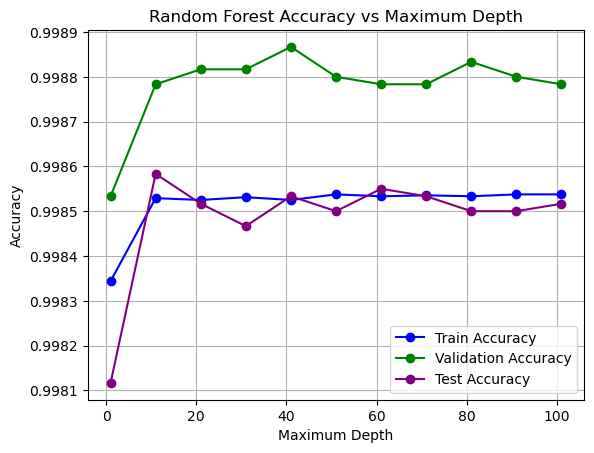

In [47]:
params = range(1, 111, 10)
train_accuracies = []
val_accuracies = []
test_accuracies = []

for param in params:
    temp_train_accuracies = []
    temp_val_accuracies = []
    temp_test_accuracies = []
    for i in range(1, 7, 1):
        trees = random_forest(X_train, y_train, 5, param, 20, 4, 6)

        train_predictions = predict_forest(X_train, trees)
        train_accuracy = accuracy(y_train, train_predictions)
        temp_train_accuracies.append(train_accuracy)

        val_predictions = predict_forest(X_val, trees)
        val_accuracy = accuracy(y_val, val_predictions)
        temp_val_accuracies.append(val_accuracy)

        test_predictions = predict_forest(X_test, trees)
        test_accuracy = accuracy(y_test, test_predictions)
        temp_test_accuracies.append(test_accuracy)
    train_accuracies.append(np.mean(temp_train_accuracies))
    val_accuracies.append(np.mean(temp_val_accuracies))
    test_accuracies.append(np.mean(temp_test_accuracies))

plt.plot(params, train_accuracies, marker='o', color='blue', label='Train Accuracy')
plt.plot(params, val_accuracies, marker='o', color='green', label='Validation Accuracy')
plt.plot(params, test_accuracies, marker='o', color='purple', label='Test Accuracy')

plt.title('Random Forest Accuracy vs Maximum Depth')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

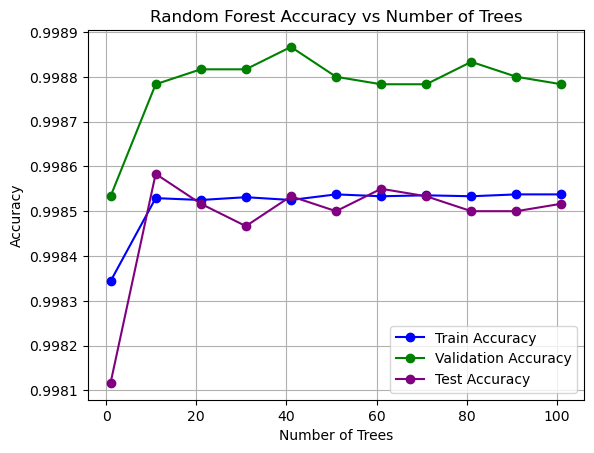

In [48]:
plt.plot(params, train_accuracies, marker='o', color='blue', label='Train Accuracy')
plt.plot(params, val_accuracies, marker='o', color='green', label='Validation Accuracy')
plt.plot(params, test_accuracies, marker='o', color='purple', label='Test Accuracy')

plt.title('Random Forest Accuracy vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()